# NeuralCora Quickstart

This notebook demonstrates the minimal NeuralCora workflow: configure the CORA dataset loader, instantiate the baseline CNN forecaster, and validate the data→model→metrics pipeline.


## Prerequisites
- Install the project in editable mode: `pip install -e .[dev]`
- Ensure the `data/NY_2013_180_360.nc` and `data/real_land_mask_180_360.nc` files exist (bundled with this repository).
- Install `matplotlib` for history plots and animations: `pip install matplotlib`.


In [1]:
from pathlib import Path
import importlib

# # required = ['torch', 'xarray', 'numpy', 'matplotlib']
# # missing = [pkg for pkg in required if importlib.util.find_spec(pkg) is None]
# # if missing:
# #     raise ModuleNotFoundError(
# #         f"Missing dependencies: {', '.join(missing)}. Install with `pip install torch xarray numpy netcdf4 matplotlib`."

# # print('Resolved device:', resolve_device('auto'))
#     )

from neuralcora.utils import load_config, resolve_device
from neuralcora.datautils import CoraDataModule
from neuralcora.modelzoo import get_model_class
from neuralcora.evaluation import evaluate_metrics
from neuralcora.training import BasicTrainer
import torch

project_root = Path.cwd()
for _ in range(3):
    if (project_root / 'data').exists():
        break
    project_root = project_root.parent

data_path = project_root / 'data/NY_2013_180_360.nc'
mask_path = project_root / 'data/real_land_mask_180_360.nc'
assert data_path.exists(), f'Data file not found: {data_path}'
assert mask_path.exists(), f'Mask file not found: {mask_path}'


In [ ]:
import yaml

# config = load_config(
#     {
#         'run_name': 'intro-notebook',
#         'data': {
#             'dataset_path': str(data_path),
#             'mask_path': str(mask_path),
#             'input_steps': 1,
#             'forecast_steps': 6,
#             'stride': 1,
#             'batch_size': 64,
#             'num_workers': 0,
#             'normalization': 'global',
#             'split_fractions': {'train': 0.8, 'val': 0.1, 'test': 0.1},
#         },
#         'model': {
#             'name': 'simple_cnn',
#             'input_channels': 1,
#             'output_channels': 6,
#             'hidden_channels': [16, 32, 32, 16],
#             'kernel_size': 3,
#             'dropout': 0.2,
#         },
#         'training': {
#             'trainer_name': 'basic',
#             'epochs': 64,
#             'learning_rate': 1e-1,
#             'log_interval': 50,
#             'device': 'auto',
#             'weight_decay': 1e-5,
#         },
#     }
# )
# config

def load_config_from_yaml(path: str):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config_dict = load_config_from_yaml("config.yml")

# Assuming your `load_config` function takes a dict:
config = load_config(config_dict)

print(config)

ExperimentConfig(seed=42, run_name='intro-notebook', data=DataConfig(dataset_name='cora', dataset_path='/Users/Work/Library/CloudStorage/GoogleDrive-yunlong.pan@stonybrook.edu/My Drive/neuralcora/data/NY_2013_180_360.nc', mask_path='/Users/Work/Library/CloudStorage/GoogleDrive-yunlong.pan@stonybrook.edu/My Drive/neuralcora/data/real_land_mask_180_360.nc', input_steps=1, forecast_steps=6, stride=1, normalization='global', stats_path=None, batch_size=2, num_workers=0, split_fractions={'train': 0.8, 'val': 0.1, 'test': 0.1}), model=ModelConfig(name='simple_cnn', input_channels=1, output_channels=6, hidden_channels=[32, 64], kernel_size=3, dropout=0.1), training=TrainingConfig(trainer_name='basic', epochs=2, learning_rate=0.1, weight_decay=0.0, device='auto', log_interval=25, save_dir='runs', gradient_clip_norm=None), notes=None)


> **Note:** The quickstart uses `BasicTrainer` for convenience, which provides `plot_history()` and `visualize_validation_sample()` to inspect training dynamics and forecasts.

In [3]:
datamodule = CoraDataModule(config.data)
datamodule.setup(stage='fit')
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
inputs = batch['inputs']
targets = batch['targets']
input_indices = batch['input_start_index'].tolist()
target_indices = batch['target_start_index'].tolist()
print(f'Inputs shape: {tuple(inputs.shape)}')
print(f'Targets shape: {tuple(targets.shape)}')
print(f'Input windows start at hours {input_indices}')
print(f'Forecast windows begin at hours {target_indices}')


/Users/Work/Library/CloudStorage/GoogleDrive-yunlong.pan@stonybrook.edu/My Drive/neuralcora/neuralcora/utils/normalization.py:25: RuntimeWarning: Mean of empty slice
  mean = float(np.nanmean(array))
/opt/anaconda3/envs/yl-demo-0917/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Inputs shape: (2, 1, 180, 360)
Targets shape: (2, 6, 180, 360)
Input windows start at hours [5521, 3332]
Forecast windows begin at hours [5522, 3333]


In [4]:
model_cls = get_model_class(config.model.name)
model = model_cls(
    input_channels=config.model.input_channels or config.data.input_steps,
    output_channels=config.model.output_channels or config.data.forecast_steps,
    hidden_channels=config.model.hidden_channels,
    kernel_size=config.model.kernel_size,
    dropout=config.model.dropout,
)
trainer = BasicTrainer(config.training)
history = trainer.fit(model, datamodule)
history

/Users/Work/Library/CloudStorage/GoogleDrive-yunlong.pan@stonybrook.edu/My Drive/neuralcora/neuralcora/utils/normalization.py:25: RuntimeWarning: Mean of empty slice
  mean = float(np.nanmean(array))
/opt/anaconda3/envs/yl-demo-0917/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Epoch 1 Step 25/3501 - Loss: 0.1716
Epoch 1 Step 50/3501 - Loss: 0.2013
Epoch 1 Step 75/3501 - Loss: 0.1570
Epoch 1 Step 100/3501 - Loss: 0.0866
Epoch 1 Step 125/3501 - Loss: 0.0882
Epoch 1 Step 150/3501 - Loss: 0.1305
Epoch 1 Step 175/3501 - Loss: 0.0684
Epoch 1 Step 200/3501 - Loss: 0.1968
Epoch 1 Step 225/3501 - Loss: 0.1118
Epoch 1 Step 250/3501 - Loss: 0.1587
Epoch 1 Step 275/3501 - Loss: 0.1210
Epoch 1 Step 300/3501 - Loss: 0.1419
Epoch 1 Step 325/3501 - Loss: 0.1371
Epoch 1 Step 350/3501 - Loss: 0.1557
Epoch 1 Step 375/3501 - Loss: 0.1292
Epoch 1 Step 400/3501 - Loss: 0.0799
Epoch 1 Step 425/3501 - Loss: 0.0961
Epoch 1 Step 450/3501 - Loss: 0.1924
Epoch 1 Step 475/3501 - Loss: 0.2012
Epoch 1 Step 500/3501 - Loss: 0.1225
Epoch 1 Step 525/3501 - Loss: 0.1281
Epoch 1 Step 550/3501 - Loss: 0.0908
Epoch 1 Step 575/3501 - Loss: 0.1376
Epoch 1 Step 600/3501 - Loss: 0.1516
Epoch 1 Step 625/3501 - Loss: 0.1175
Epoch 1 Step 650/3501 - Loss: 0.1113
Epoch 1 Step 675/3501 - Loss: 0.1513
Epoc

[{'epoch': 1,
  'train_mse': 0.15816744352735831,
  'train_mse_normalized': 0.15816744352735831,
  'val_mse': 0.11049510638939736,
  'val_mse_normalized': 0.11049510638939736,
  'val_rmse': 0.32443593683988536,
  'val_metrics': {'rmse': 0.32443593683988536,
   'mae': 0.22514859615871896,
   'bias': 0.009380455786475516,
   'nrmse': 0.1435056235045875,
   'pearson_corr': -0.00753091799614092}},
 {'epoch': 2,
  'train_mse': 0.12506487243509537,
  'train_mse_normalized': 0.12506487243509537,
  'val_mse': 0.11068135203546993,
  'val_mse_normalized': 0.11068135203546993,
  'val_rmse': 0.32532403107783564,
  'val_metrics': {'rmse': 0.32532403107783564,
   'mae': 0.23279380667359317,
   'bias': 0.04557841094120376,
   'nrmse': 0.14400837886823367,
   'pearson_corr': -0.008478820613121878}}]

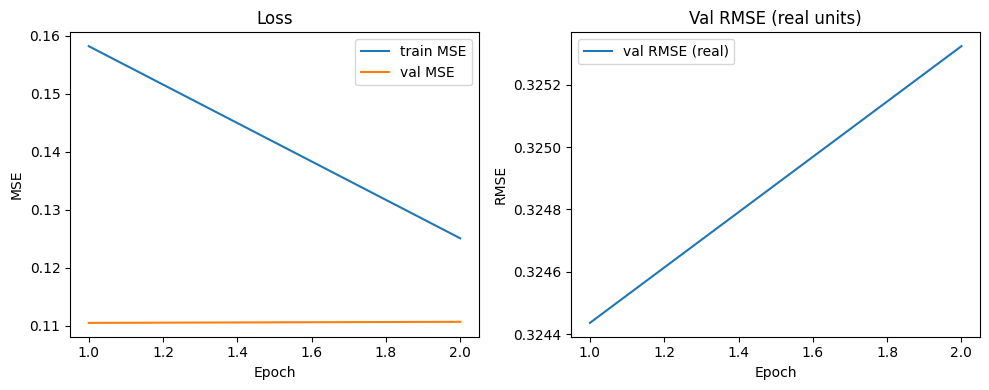

In [5]:
trainer.plot_history()

In [ ]:
fig, anim = trainer.visualize_validation_sample()
from IPython.display import HTML
HTML(anim.to_jshtml())

## Next Steps
- Use `neuralcora.run.train` to execute multi-epoch experiments from YAML config files.
- Experiment with deeper CNN architectures or alternative normalization strategies in `config.model`.
- Customize visualization (additional channels, horizons) to inspect coastal surge behaviour across events.
